## SetUp

In [57]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## Data Analisys

In [1]:
SCREEN_WIDTH = 1920
SCREEN_HEIGHT = 1080
GRID_COLS = 5
GRID_ROWS = 5
print(f"cell size = {SCREEN_WIDTH/GRID_COLS}x{SCREEN_HEIGHT/GRID_ROWS}")

cell size = 384.0x216.0


In [4]:
# load database
df = pd.read_csv('../clean_data/cleaned_eye_data.csv')
df.head()

,File Path Face Image,File Path Left Eye Image,File Path Right Eye Image,x,y
0,face_image_1.png,left_eye_image_1.png,right_eye_image_1.png,1664,624
1,face_image_2.png,left_eye_image_2.png,right_eye_image_2.png,1559,434
2,face_image_4.png,left_eye_image_4.png,right_eye_image_4.png,377,862
3,face_image_5.png,left_eye_image_5.png,right_eye_image_5.png,750,611
4,face_image_7.png,left_eye_image_7.png,right_eye_image_7.png,524,309


In [19]:
# add 3 images img_face, img_left_eye, img_right_eye togheter to show them at once
def add_images(img_face, img_left_eye, img_right_eye):
    new_img = Image.new('RGB', (235, 190), (255, 255, 255))
    new_img.paste(img_face, (0, 0))
    new_img.paste(img_left_eye, (190, 0))
    new_img.paste(img_right_eye, (190, 45))
    return new_img

395 531


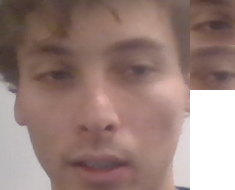

In [27]:
# show image 1, left eye 1 and right eye 1
face_path = df.iloc[10]['File Path Face Image']
face_path = '../data_collection_phase/data/saved_images/' + face_path
left_eye_path = df.iloc[10]['File Path Left Eye Image']
left_eye_path = '../data_collection_phase/data/saved_images/' + left_eye_path
right_eye_path = df.iloc[10]['File Path Right Eye Image']
right_eye_path = '../data_collection_phase/data/saved_images/' + right_eye_path

img_face = Image.open(face_path)
img_left_eye = Image.open(left_eye_path)
img_right_eye = Image.open(right_eye_path)

print(df.iloc[10]['x'], df.iloc[10]['y'])
add_images(img_face, img_left_eye, img_right_eye)

## Make it classification of cell in screen

In [23]:
# screen is 1920x1080
# we will divide it into 5x5 grid
# so each cell will be 384x216
# so cell 0 will be from (0,0) to (384,216), and so on
# cell 0 top left corner, cell 1 next to it, and so on
df_class = df.copy()
df_class['cell'] = (df['x'] // (SCREEN_WIDTH/GRID_COLS)) + (df['y'] // (SCREEN_HEIGHT/GRID_ROWS)) * GRID_COLS
df_class['cell'] = df_class['cell'].astype(int)
df_class.head()

,File Path Face Image,File Path Left Eye Image,File Path Right Eye Image,x,y,cell
0,face_image_1.png,left_eye_image_1.png,right_eye_image_1.png,1664,624,14
1,face_image_2.png,left_eye_image_2.png,right_eye_image_2.png,1559,434,14
2,face_image_4.png,left_eye_image_4.png,right_eye_image_4.png,377,862,15
3,face_image_5.png,left_eye_image_5.png,right_eye_image_5.png,750,611,11
4,face_image_7.png,left_eye_image_7.png,right_eye_image_7.png,524,309,6


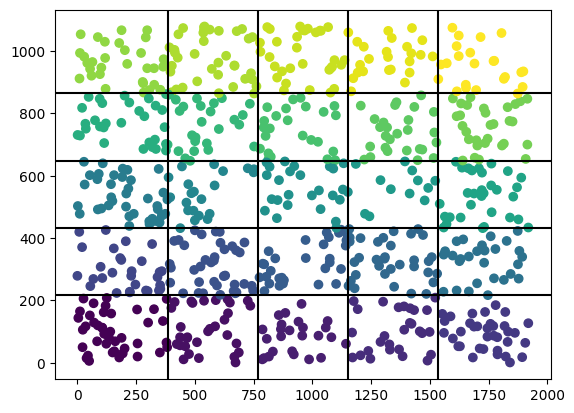

In [25]:
# plot points x,y on graph and color them based on cell
plt.scatter(df_class['x'], df_class['y'], c=df_class['cell'])
# add grid lines
for i in range(1, GRID_COLS):
    plt.axvline(i * (SCREEN_WIDTH/GRID_COLS), color='k')
for i in range(1, GRID_ROWS):
    plt.axhline(i * (SCREEN_HEIGHT/GRID_ROWS), color='k')
plt.show()

## Train-Test split

In [53]:
# File Path Face Image	File Path Left Eye Image	File Path Right Eye Image	x	y	cell
# drop x and y colunms
df = df_class.copy()
df = df.drop(columns=['x', 'y'])
df.head()

,File Path Face Image,File Path Left Eye Image,File Path Right Eye Image,cell
0,face_image_1.png,left_eye_image_1.png,right_eye_image_1.png,14
1,face_image_2.png,left_eye_image_2.png,right_eye_image_2.png,14
2,face_image_4.png,left_eye_image_4.png,right_eye_image_4.png,15
3,face_image_5.png,left_eye_image_5.png,right_eye_image_5.png,11
4,face_image_7.png,left_eye_image_7.png,right_eye_image_7.png,6


In [54]:
# split target and features
X = df.drop(columns=['cell'])
y = df['cell']

In [55]:
all_images = [X['File Path Face Image'].tolist(), X['File Path Left Eye Image'].tolist(), X['File Path Right Eye Image'].tolist()]
images = [[np.array(Image.open('../data_collection_phase/data/saved_images/'+path)) for path in i] for i in all_images]
images = [np.array(i, dtype=np.float32) / 255.0  for i in images] # Ensure dtype is float32
#len(images) # -> 3
#len(images[0]), len(images[1]), len(images[2]) # -> 734, 734, 734
#type(images[0]) # -> list
#type(images[0][0]) # -> numpy.ndarray

In [56]:
y = np.array(df['cell'].tolist()).reshape(-1, 1)
y[0]

array([14])

In [58]:
x_train, x_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [3, 734]